# An Overview on Probabilistic Programming with Python and PyMC3
<img src="./Images/PyMC3Logo.png" alt="PyMC3 logo" style="height: 200px; width:186px;"/>

In [1]:
import theano.tensor as tt
import math
from scipy import stats
import pandas as pd
import arviz as az
import warnings
import pymc3 as pm
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from IPython.core.pylabtools import figsize
from jupyterthemes import jtplot

warnings.simplefilter(action="ignore", category=FutureWarning)

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
az.style.use("arviz-darkgrid")
jtplot.style(theme='monokai', context='notebook', ticks=True, grid=False)
print(f"Running on PyMC3 v{pm.__version__}")
print(f"Running on ArviZ v{az.__version__}")

Running on PyMC3 v3.11.1
Running on ArviZ v0.11.2


## Summary
---
_PyMC3 is a probabilistic programming package for Python that allows users to fit Bayesian models using a variety of numerical methods, most notably Markov chain Monte Carlo (MCMC) and variational inference (VI). Its flexibility and extensibility make it applicable to a large suite of problems. Along with core model specification and fitting functionality, PyMC3 includes functionality for summarizing output and for model diagnostics._

Features include:
+ Gradient-based MCMC methods, including Hamiltonian Monte Carlo (HMC), the No U-turn Sampler (NUTS), and Stein Variational Gradient Descent.
+ Variational inference methods, including automatic differentiation variational inference (ADVI) and operator variational inference (OPVI).
+ An interface for easy formula-based specification of generalized linear models (GLM).
+ Includes a large suite of well-documented statistical distributions.
+ Uses Theano as the computational backend, allowing for fast expression evaluation, automatic gradient calculation, and GPU computing.
+ Built-in support for Gaussian process modeling.
+ Model summarization and plotting.
+ Model checking and convergence detection.
+ Extensible: easily incorporates custom step methods and unusual probability distributions.
+ Bayesian models can be embedded in larger programs, and results can be analyzed with the full power of Python.


## Story Telling: The Math Way
---

_Probabilistic programming will unlock narrative explanations of data, one of the holy grails of business analytics and the unsung hero of scientific persuasion. People think in terms of stories - thus the unreasonable power of the anecdote to drive decision-making, well-founded or not. But existing analytics largely fails to provide this kind of story; instead, numbers seemingly appear out of thin air, with little of the causal context that humans prefer when weighing their options._ - B.Cronin
    
Below is an example on how one might go about using PyMC3 to infer over some data. **NOTE:** this example, while modified, was taken from the first and second chapters of Cam Davidson's Probabilistic Programming and Bayesian Methods for Hackers book.  

### Setup
Assume that we have been given some data regarding the frequency on text messages received for some person, lets call him Donuts. We would like to know if there is a shift in his texting behavior over the time period of the data. For demonstration purposes, this data is going to all be fake and randomly generated based. We can do this by thinking through how this data might be represented if it were actually real. (_Note:_ in the book, the data in the first chapter is actually real and not generated.)

### Data Generation
1. We started by thinking "what is the best random variable to describe this count data?" A Poisson random variable is a good candidate because it can represent count data. So we model the number of sms's received as sampled from a Poisson distribution.
2. Next, we think, "Ok, assuming sms's are Poisson-distributed, what do I need for the Poisson distribution?" Well, the Poisson distribution has a parameter $\lambda$.
3. Do we know $\lambda$? No. In fact, we have a suspicion that there are two $\lambda$ values, one for the earlier behaviour and one for the later behaviour. We don't know when the behaviour switches though, but call the switchpoint $\tau$.
4. What is a good distribution for the two $\lambda$s? The exponential is good, as it assigns probabilities to positive real numbers. Well the exponential distribution has a parameter too, call it $\alpha$.
5. Do we know what the parameter $\alpha$ might be? No. At this point, we could continue and assign a distribution to $\alpha$, but it's better to stop once we reach a set level of ignorance: whereas we have a prior belief about $\lambda$, ("it probably changes over time", "it's likely between 10 and 30", etc.), we don't really have any strong beliefs about $\alpha$. So it's best to stop here. What is a good value for $\alpha$ then? We think that the $\lambda$s are between 10-30, so if we set $\alpha$ really low (which corresponds to larger probability on high values) we are not reflecting our prior well. Similar, a too-high alpha misses our prior belief as well. A good idea for $\alpha$ as to reflect our belief is to set the value so that the mean of $\lambda$, given $\alpha$, is equal to our observed mean. This was shown in the last chapter.
6. We have no expert opinion of when $\tau$ might have occurred. So we will suppose $\tau$ is from a discrete uniform distribution over the entire timespan.

With a plan set up on how we believe this data setup, we can just straight up randomly choose values for the $\lambda$s and $\tau$ to get some fake data. Then with that, we can put that data through pymc3 to try and guess what $\lambda_1$, $\lambda_2$, and $\tau$ are (pretending we didn't just make a whole bunch of data). This exercise is impractical but thats not the point.
    

lambda1		18
lambda2		23
tau		44


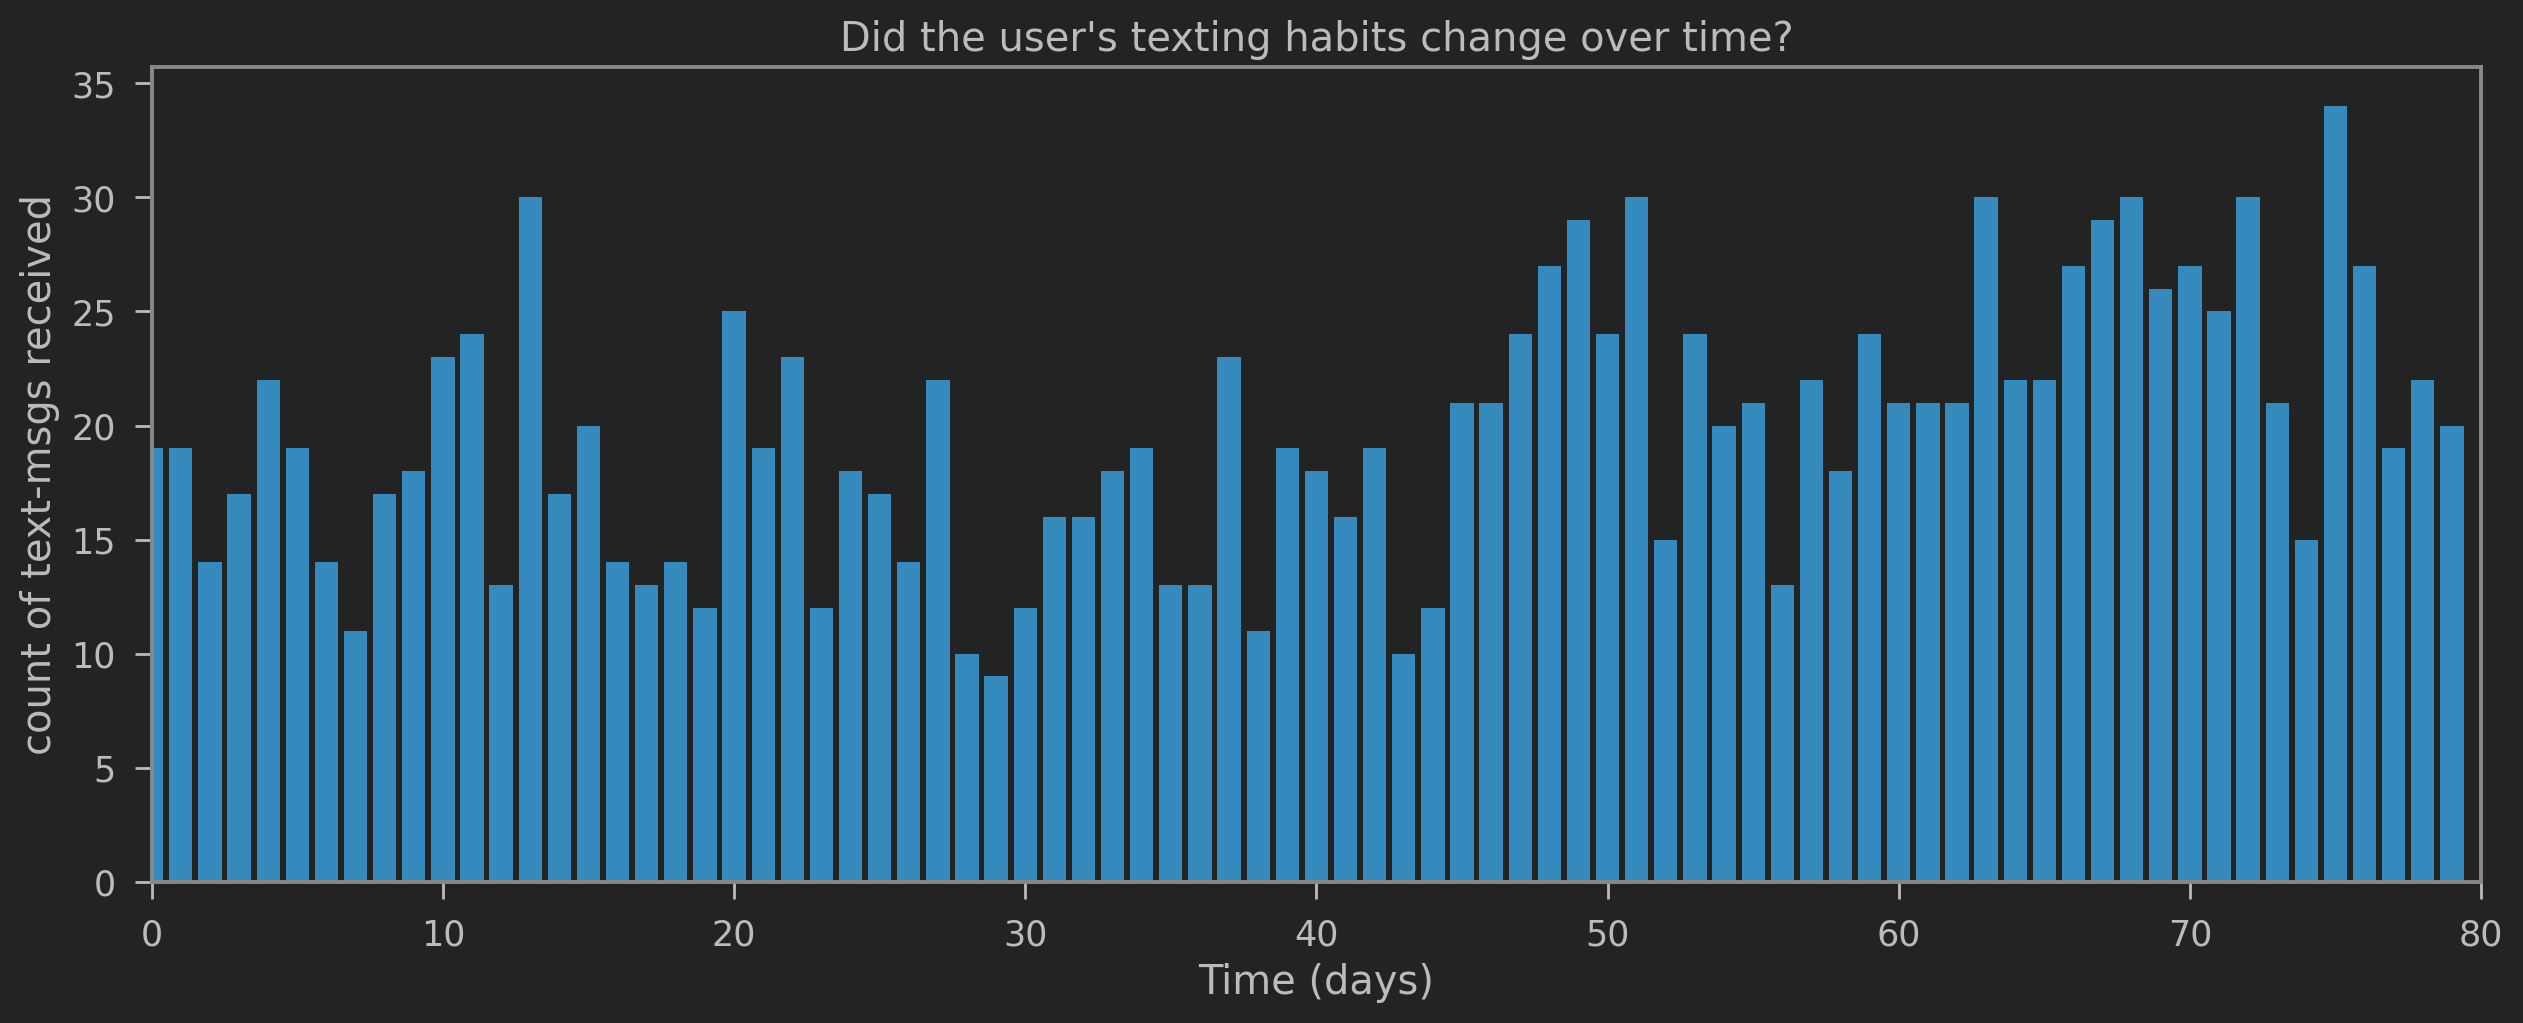

In [2]:
# tau = np.random.randint(0, 80)
# alpha = 1./20.
# lambda_1, lambda_2 = np.random.exponential(scale=1/alpha, size=2)

tau = 44
lambda_1, lambda_2 = 18, 23
print(f"lambda1\t\t{lambda_1}\nlambda2\t\t{lambda_2}\ntau\t\t{tau}")

# Fake data generation with our randomly pulled parameters
count_data = np.r_[stats.poisson.rvs(
    mu=lambda_1, size=tau), stats.poisson.rvs(mu=lambda_2, size=80 - tau)]
n_count_data = len(count_data)

# Bar chart of data
figsize(12.5, 5)
plt.bar(np.arange(n_count_data), count_data, color="#348ABD")
plt.xlabel("Time (days)")
plt.ylabel("count of text-msgs received")
plt.title("Did the user's texting habits change over time?")
plt.xlim(0, n_count_data)

### Inference

Now that we have our data, we can actually use it to answer the original question. By basically reversing the process we did to generate the data, we can make a model which will then be pushed through the PyMC3 back-end. We start by giving each parameter their appropriate prior distributions and then make an observation variable which is where all of the generated data goes. Finally we can sample our model with a step function and then sample from the posterior with the `pm.sample()` method. This method has a ton of options as its really the heart of PyMC3. Below is the doc string:

```python
Signature:
pm.sample(
    draws=1000,
    step=None,
    init='auto',
    n_init=200000,
    start=None,
    trace=None,
    chain_idx=0,
    chains=None,
    cores=None,
    tune=1000,
    progressbar=True,
    model=None,
    random_seed=None,
    discard_tuned_samples=True,
    compute_convergence_checks=True,
    callback=None,
    jitter_max_retries=10,
    *,
    return_inferencedata=None,
    idata_kwargs: dict = None,
    mp_ctx=None,
    pickle_backend: str = 'pickle',
    **kwargs,
)
Docstring:
Draw samples from the posterior using the given step methods.

Multiple step methods are supported via compound step methods.

Parameters
----------
draws : int
    The number of samples to draw. Defaults to 1000. The number of tuned samples are discarded
    by default. See ``discard_tuned_samples``.
init : str
    Initialization method to use for auto-assigned NUTS samplers.

    * auto: Choose a default initialization method automatically.
      Currently, this is ``jitter+adapt_diag``, but this can change in the future.
      If you depend on the exact behaviour, choose an initialization method explicitly.
    * adapt_diag: Start with a identity mass matrix and then adapt a diagonal based on the
      variance of the tuning samples. All chains use the test value (usually the prior mean)
      as starting point.
    * jitter+adapt_diag: Same as ``adapt_diag``, but add uniform jitter in [-1, 1] to the
      starting point in each chain.
    * advi+adapt_diag: Run ADVI and then adapt the resulting diagonal mass matrix based on the
      sample variance of the tuning samples.
    * advi+adapt_diag_grad: Run ADVI and then adapt the resulting diagonal mass matrix based
      on the variance of the gradients during tuning. This is **experimental** and might be
      removed in a future release.
    * advi: Run ADVI to estimate posterior mean and diagonal mass matrix.
    * advi_map: Initialize ADVI with MAP and use MAP as starting point.
    * map: Use the MAP as starting point. This is discouraged.
    * adapt_full: Adapt a dense mass matrix using the sample covariances

step : function or iterable of functions
    A step function or collection of functions. If there are variables without step methods,
    step methods for those variables will be assigned automatically.  By default the NUTS step
    method will be used, if appropriate to the model; this is a good default for beginning
    users.
n_init : int
    Number of iterations of initializer. Only works for 'ADVI' init methods.
start : dict, or array of dict
    Starting point in parameter space (or partial point)
    Defaults to ``trace.point(-1))`` if there is a trace provided and model.test_point if not
    (defaults to empty dict). Initialization methods for NUTS (see ``init`` keyword) can
    overwrite the default.
trace : backend, list, or MultiTrace
    This should be a backend instance, a list of variables to track, or a MultiTrace object
    with past values. If a MultiTrace object is given, it must contain samples for the chain
    number ``chain``. If None or a list of variables, the NDArray backend is used.
chain_idx : int
    Chain number used to store sample in backend. If ``chains`` is greater than one, chain
    numbers will start here.
chains : int
    The number of chains to sample. Running independent chains is important for some
    convergence statistics and can also reveal multiple modes in the posterior. If ``None``,
    then set to either ``cores`` or 2, whichever is larger.
cores : int
    The number of chains to run in parallel. If ``None``, set to the number of CPUs in the
    system, but at most 4.
tune : int
    Number of iterations to tune, defaults to 1000. Samplers adjust the step sizes, scalings or
    similar during tuning. Tuning samples will be drawn in addition to the number specified in
    the ``draws`` argument, and will be discarded unless ``discard_tuned_samples`` is set to
    False.
progressbar : bool, optional default=True
    Whether or not to display a progress bar in the command line. The bar shows the percentage
    of completion, the sampling speed in samples per second (SPS), and the estimated remaining
    time until completion ("expected time of arrival"; ETA).
model : Model (optional if in ``with`` context)
random_seed : int or list of ints
    A list is accepted if ``cores`` is greater than one.
discard_tuned_samples : bool
    Whether to discard posterior samples of the tune interval.
compute_convergence_checks : bool, default=True
    Whether to compute sampler statistics like Gelman-Rubin and ``effective_n``.
callback : function, default=None
    A function which gets called for every sample from the trace of a chain. The function is
    called with the trace and the current draw and will contain all samples for a single trace.
    the ``draw.chain`` argument can be used to determine which of the active chains the sample
    is drawn from.
    Sampling can be interrupted by throwing a ``KeyboardInterrupt`` in the callback.
jitter_max_retries : int
    Maximum number of repeated attempts (per chain) at creating an initial matrix with uniform jitter
    that yields a finite probability. This applies to ``jitter+adapt_diag`` and ``jitter+adapt_full``
    init methods.
return_inferencedata : bool, default=False
    Whether to return the trace as an :class:`arviz:arviz.InferenceData` (True) object or a `MultiTrace` (False)
    Defaults to `False`, but we'll switch to `True` in an upcoming release.
idata_kwargs : dict, optional
    Keyword arguments for :func:`arviz:arviz.from_pymc3`
mp_ctx : multiprocessing.context.BaseContent
    A multiprocessing context for parallel sampling. See multiprocessing
    documentation for details.
pickle_backend : str
    One of `'pickle'` or `'dill'`. The library used to pickle models
    in parallel sampling if the multiprocessing context is not of type
    `fork`.

Returns
-------
trace : pymc3.backends.base.MultiTrace or arviz.InferenceData
    A ``MultiTrace`` or ArviZ ``InferenceData`` object that contains the samples.

Notes
-----
Optional keyword arguments can be passed to ``sample`` to be delivered to the
``step_method``\ s used during sampling.

If your model uses only one step method, you can address step method kwargs
directly. In particular, the NUTS step method has several options including:

    * target_accept : float in [0, 1]. The step size is tuned such that we
      approximate this acceptance rate. Higher values like 0.9 or 0.95 often
      work better for problematic posteriors
    * max_treedepth : The maximum depth of the trajectory tree
    * step_scale : float, default 0.25
      The initial guess for the step size scaled down by :math:`1/n**(1/4)`

If your model uses multiple step methods, aka a Compound Step, then you have
two ways to address arguments to each step method:

A. If you let ``sample()`` automatically assign the ``step_method``\ s,
   and you can correctly anticipate what they will be, then you can wrap
   step method kwargs in a dict and pass that to sample() with a kwarg set
   to the name of the step method.
   e.g. for a CompoundStep comprising NUTS and BinaryGibbsMetropolis,
   you could send:

   1. ``target_accept`` to NUTS: nuts={'target_accept':0.9}
   2. ``transit_p`` to BinaryGibbsMetropolis: binary_gibbs_metropolis={'transit_p':.7}

   Note that available names are:

    ``nuts``, ``hmc``, ``metropolis``, ``binary_metropolis``,
    ``binary_gibbs_metropolis``, ``categorical_gibbs_metropolis``,
    ``DEMetropolis``, ``DEMetropolisZ``, ``slice``

B. If you manually declare the ``step_method``\ s, within the ``step``
   kwarg, then you can address the ``step_method`` kwargs directly.
   e.g. for a CompoundStep comprising NUTS and BinaryGibbsMetropolis,
   you could send ::

    step=[pm.NUTS([freeRV1, freeRV2], target_accept=0.9),
          pm.BinaryGibbsMetropolis([freeRV3], transit_p=.7)]

You can find a full list of arguments in the docstring of the step methods.

Examples
--------
.. code:: ipython

    In [1]: import pymc3 as pm
       ...: n = 100
       ...: h = 61
       ...: alpha = 2
       ...: beta = 2

    In [2]: with pm.Model() as model: # context management
       ...:     p = pm.Beta("p", alpha=alpha, beta=beta)
       ...:     y = pm.Binomial("y", n=n, p=p, observed=h)
       ...:     trace = pm.sample()

    In [3]: az.summary(trace, kind="stats")

    Out[3]:
        mean     sd  hdi_3%  hdi_97%
    p  0.609  0.047   0.528    0.699
File:      /opt/conda/lib/python3.8/site-packages/pymc3/sampling.py
Type:      function
```

In [18]:
with pm.Model() as model:
    alpha = 1.0/count_data.mean()
    lambda_1 = pm.Exponential("lambda_1", alpha)
    lambda_2 = pm.Exponential("lambda_2", alpha)
    tau = pm.DiscreteUniform("tau", lower=0, upper=n_count_data - 1)

    idx = np.arange(n_count_data)  # Index
    lambda_ = pm.math.switch(tau > idx, lambda_1, lambda_2)

    observation = pm.Poisson("obs", lambda_, observed=count_data) # Prior
    prior = pm.sample_prior_predictive()
    trace = pm.sample(10000, tune=5000)
    posterior = pm.sample_posterior_predictive(trace)
#     step = pm.Metropolis()
data = az.from_pymc3(
    trace=trace,
    prior=prior,
    posterior_predictive=posterior,
    model=model
)

lambda_1_samples = trace['lambda_1']
lambda_2_samples = trace['lambda_2']
tau_samples = trace['tau']

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [lambda_2, lambda_1]
>Metropolis: [tau]


Sampling 4 chains for 5_000 tune and 10_000 draw iterations (20_000 + 40_000 draws total) took 11 seconds.
The number of effective samples is smaller than 25% for some parameters.


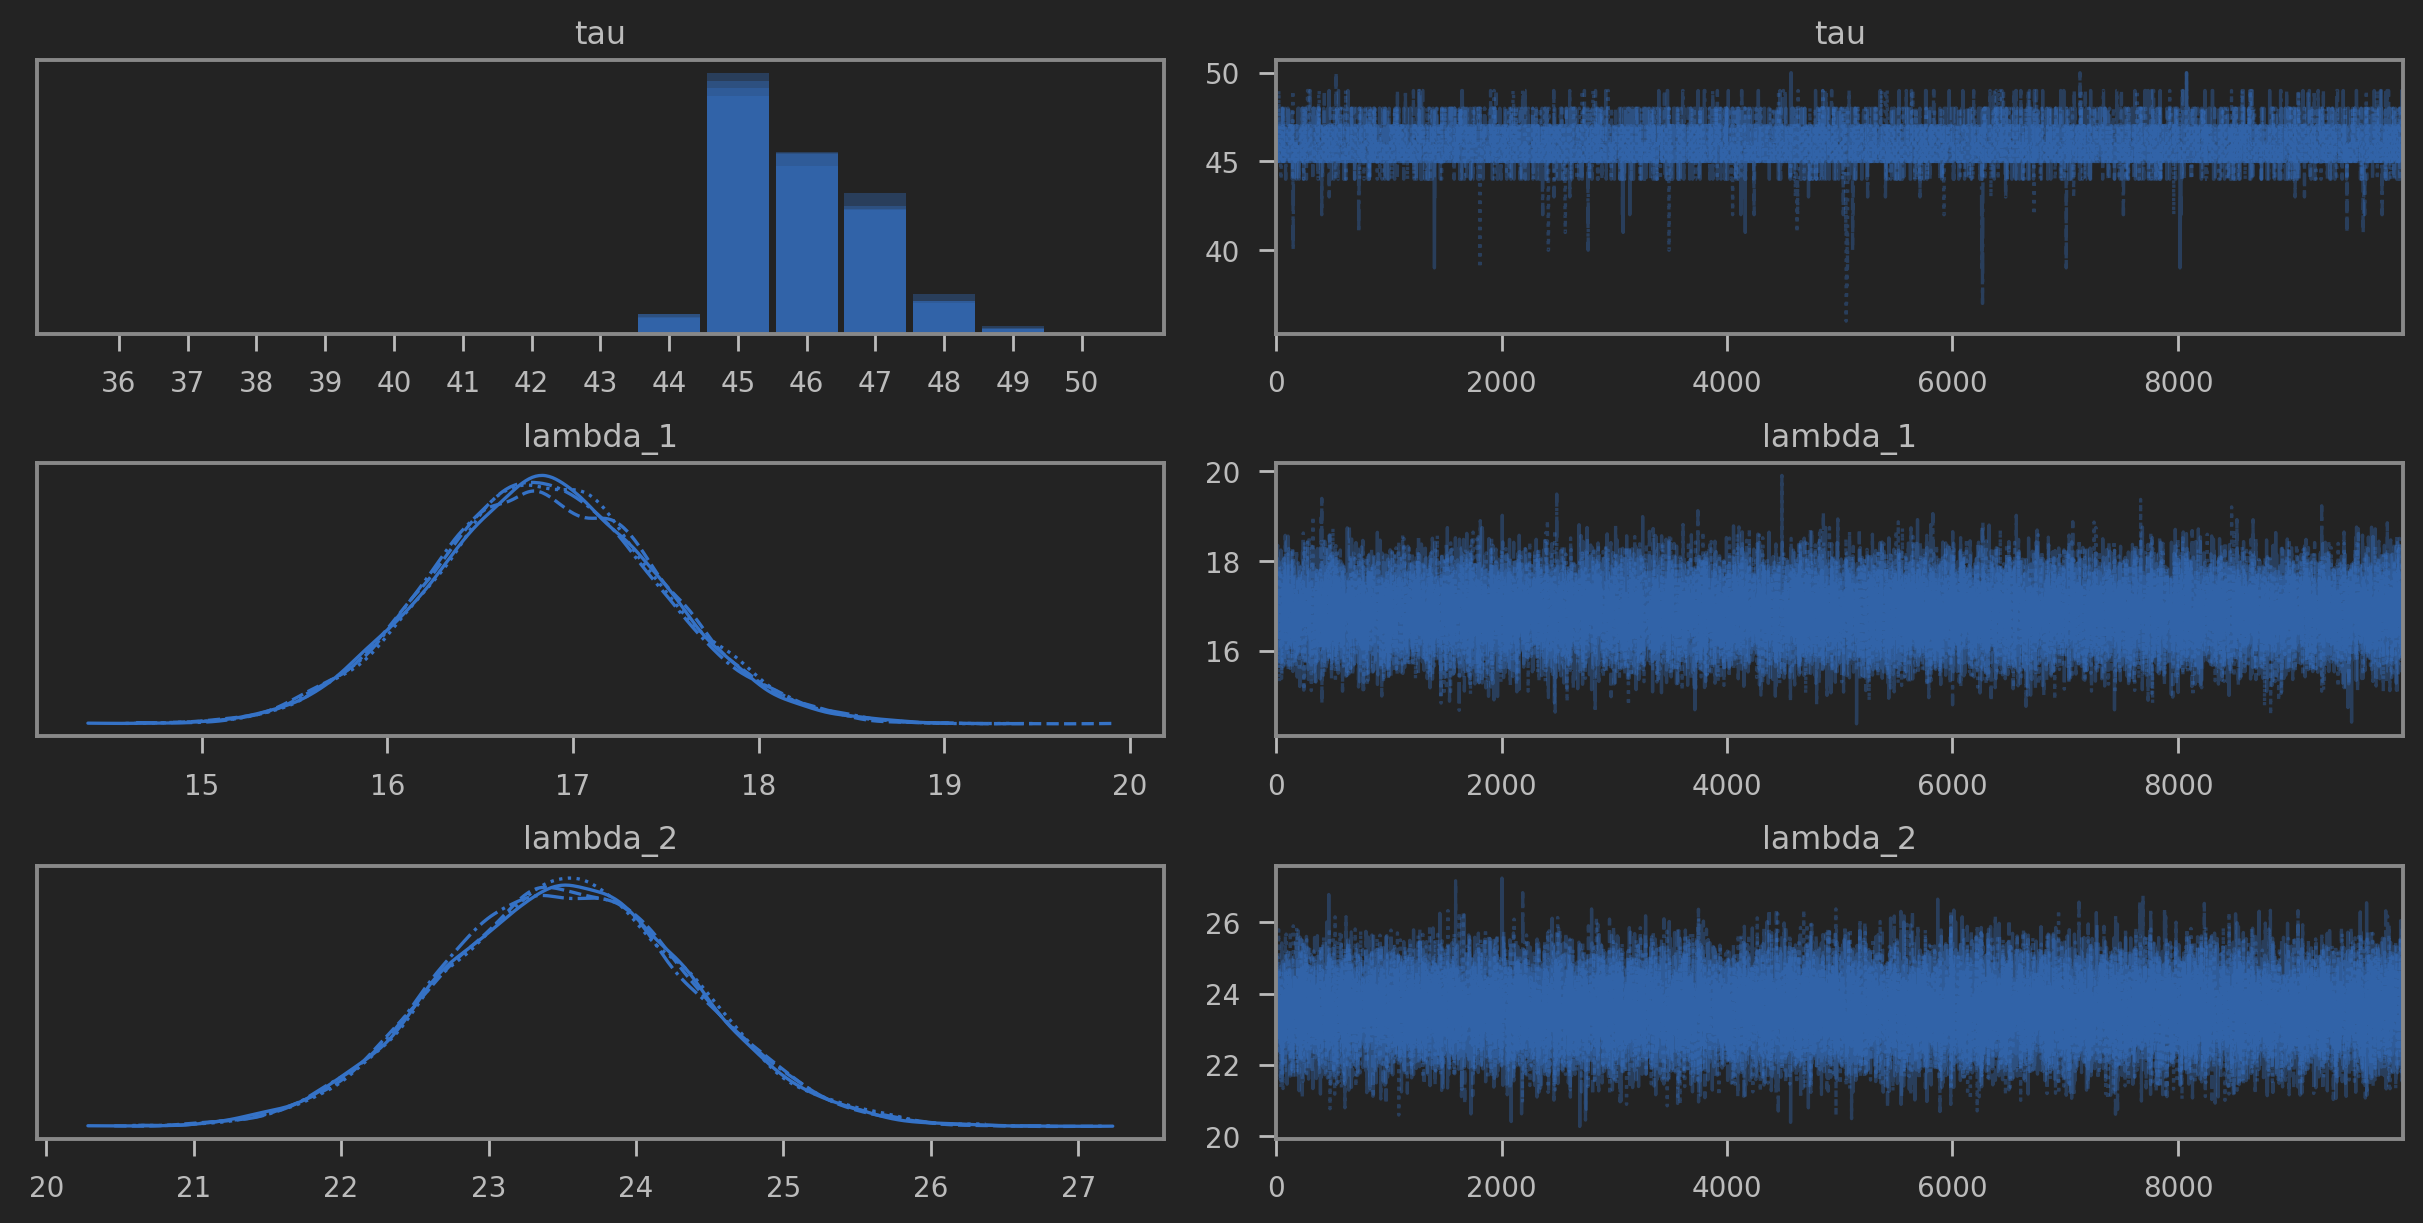

In [31]:
figsize(12.5, 5)
az.plot_trace(data)
plt.show()

### Results

Finally, using our newly found values for the lambdas and the switching points, we can plug them all in and, using the law of large numbers, determine what the expected value of texts are per day. Changes in that number answer the question of where there was a change in behavior in texing frequency. As we can see from the graphs (both above and below) it looks like there is a change in texting frequency from around 18-19 a day ($\lambda_1$) to 23-24 per day ($\lambda_2$) and it happens at around the 43-46th day ($\tau$). Comparing these results with what our generated data was given, we can see that our inference was pretty dang close to the actual data ($\lambda_1 = 18$, $\lambda_2 = 23$ and $\tau = 44$)

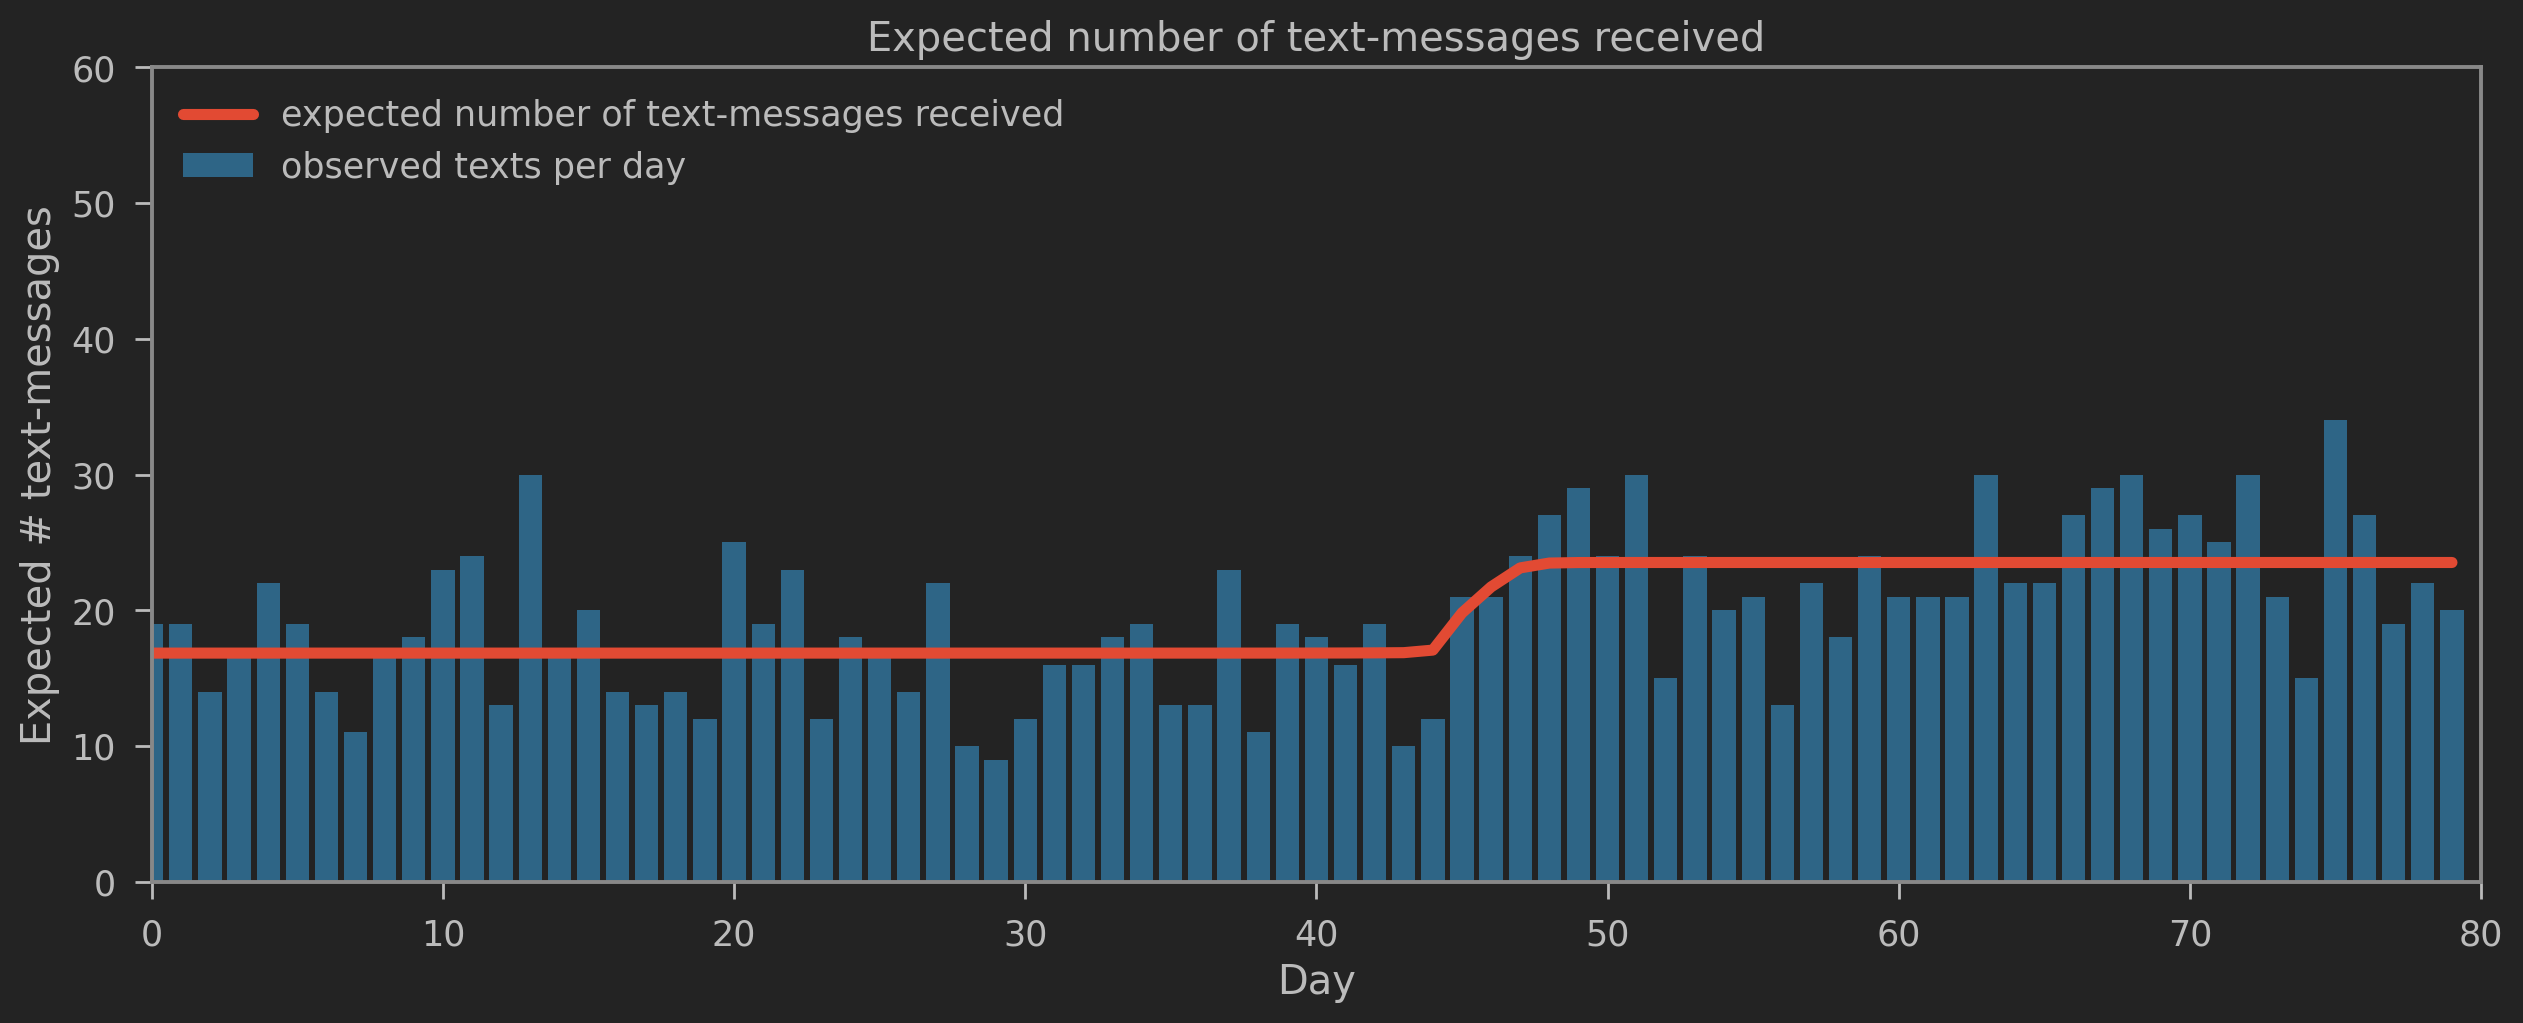

In [9]:
figsize(12.5, 5)
# tau_samples, lambda_1_samples, lambda_2_samples contain
# N samples from the corresponding posterior distribution
N = tau_samples.shape[0]
expected_texts_per_day = np.zeros(n_count_data)
for day in range(0, n_count_data):
    # ix is a bool index of all tau samples corresponding to
    # the switchpoint occurring prior to value of 'day'
    ix = day < tau_samples
    # Each posterior sample corresponds to a value for tau.
    # for each day, that value of tau indicates whether we're "before"
    # (in the lambda1 "regime") or
    #  "after" (in the lambda2 "regime") the switchpoint.
    # by taking the posterior sample of lambda1/2 accordingly, we can average
    # over all samples to get an expected value for lambda on that day.
    # As explained, the "message count" random variable is Poisson distributed,
    # and therefore lambda (the poisson parameter) is the expected value of
    # "message count".
    expected_texts_per_day[day] = (lambda_1_samples[ix].sum()
                                   + lambda_2_samples[~ix].sum()) / N


plt.plot(range(n_count_data), expected_texts_per_day, lw=4, color="#E24A33",
         label="expected number of text-messages received")
plt.xlim(0, n_count_data)
plt.xlabel("Day")
plt.ylabel("Expected # text-messages")
plt.title("Expected number of text-messages received")
plt.ylim(0, 60)
plt.bar(np.arange(len(count_data)), count_data, color="#348ABD", alpha=0.65,
        label="observed texts per day")

plt.legend(loc="upper left")

### Using the VI API

As of recently, PyMC3 has implemented some Variational Inference methods which offer some quick (though possibly less accurate) models. Rather than sampling over some specified step function like in MCMC, VI's approach is to _obtain inference from model, then calculate expressions based on this model afterwards._ The syntax is pretty compact and all of the heavy lifting is done with the `pm.fit()` method. Below is the doc string for how it works:

```python
Signature:
pm.fit(
    n=10000,
    local_rv=None,
    method='advi',
    model=None,
    random_seed=None,
    start=None,
    inf_kwargs=None,
    **kwargs,
)
Docstring:
Handy shortcut for using inference methods in functional way

Parameters
----------
n: `int`
    number of iterations
local_rv: dict[var->tuple]
    mapping {model_variable -> approx params}
    Local Vars are used for Autoencoding Variational Bayes
    See (AEVB; Kingma and Welling, 2014) for details
method: str or :class:`Inference`
    string name is case insensitive in:

    -   'advi'  for ADVI
    -   'fullrank_advi'  for FullRankADVI
    -   'svgd'  for Stein Variational Gradient Descent
    -   'asvgd'  for Amortized Stein Variational Gradient Descent
    -   'nfvi'  for Normalizing Flow with default `scale-loc` flow
    -   'nfvi=<formula>'  for Normalizing Flow using formula

model: :class:`Model`
    PyMC3 model for inference
random_seed: None or int
    leave None to use package global RandomStream or other
    valid value to create instance specific one
inf_kwargs: dict
    additional kwargs passed to :class:`Inference`
start: `Point`
    starting point for inference
Returns
-------
:class:`Approximation`
File:      /opt/conda/lib/python3.8/site-packages/pymc3/variational/inference.py
Type:      function
```

**Example: Determining Cheating**  
To show how to use some of these, lets take a look at another examples from Cam Davidson's Probabilistic Programming and Bayesian Methods for Hackers book. Suppose we want to find the frequency of students cheating on an exam. Now, anyone in their right might is not just going to openly admit they cheated so our observations are going to have to be collected using what Davidson calls the Privacy Algorithm:

    In the interview process for each student, the student flips a coin, hidden from the interviewer. The student agrees to answer honestly if the coin comes up heads. Otherwise, if the coin comes up tails, the student (secretly) flips the coin again, and answers "Yes, I did cheat" if the coin flip lands heads, and "No, I did not cheat", if the coin flip lands tails. This way, the interviewer does not know if a "Yes" was the result of a guilty plea, or a Heads on a second coin toss. Thus privacy is preserved and the researchers receive honest answers.
   
Cool. With this in mind, our prior belief is still pretty ignorant so we can start things off by beginning using a uniform distribution. **_A note on Variational Inference:_** this method does not actually work with Discrete distributions as of now. Even though this model will include a Binomial, it should be noted that its only for the observed data and not the parameters we want to inference on.  

Once that is set up, we can use the equation  
$P($Yes$) = P($Heads on first$) P($cheater$)+P($Tails on first$)P($Heads on second$) = \frac{p}{2}+\frac{1}{4}$  
to find the skewed number of yes's for our observed data. The $p$ represents the real frequency and we can take the posterior of that from the trace.

In [10]:
with pm.Model() as model:
    p = pm.Uniform("freq_cheating", 0, 1)
    p_skewed = pm.Deterministic("p_skewed", 0.5*p + 0.25)
    yes_responses = pm.Binomial("number_cheaters", 100, p_skewed, observed=35)
    mean_field = pm.fit(method="advi")

Finished [100%]: Average Loss = 4.0044


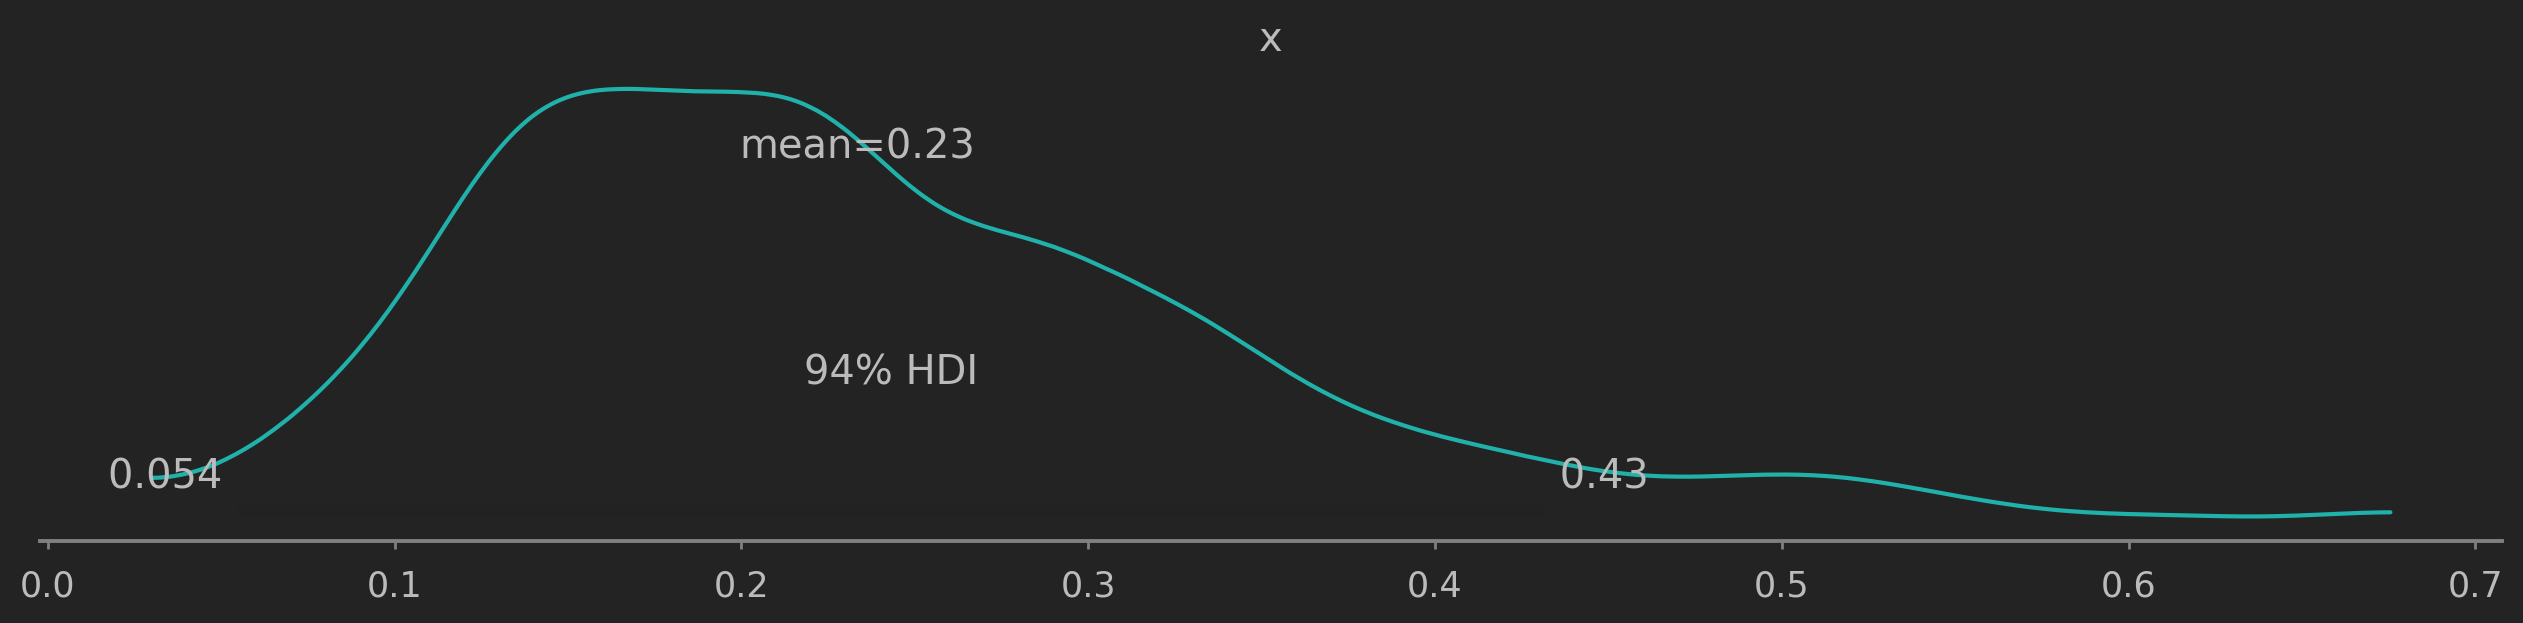

In [11]:
figsize(12.5, 3)
az.plot_posterior(mean_field.sample(1000)["freq_cheating"], color="LightSeaGreen");

In [12]:
with pm.Model() as svgd_model:
    p = pm.Uniform("freq_cheating", 0, 1)
    p_skewed = pm.Deterministic("p_skewed", 0.5*p + 0.25)
    yes_responses = pm.Binomial("number_cheaters", 100, p_skewed, observed=35)
    svgd_approx = pm.fit(
        300,
        method="svgd",
        inf_kwargs=dict(n_particles=1000),
        obj_optimizer=pm.sgd(learning_rate=0.01),
    )

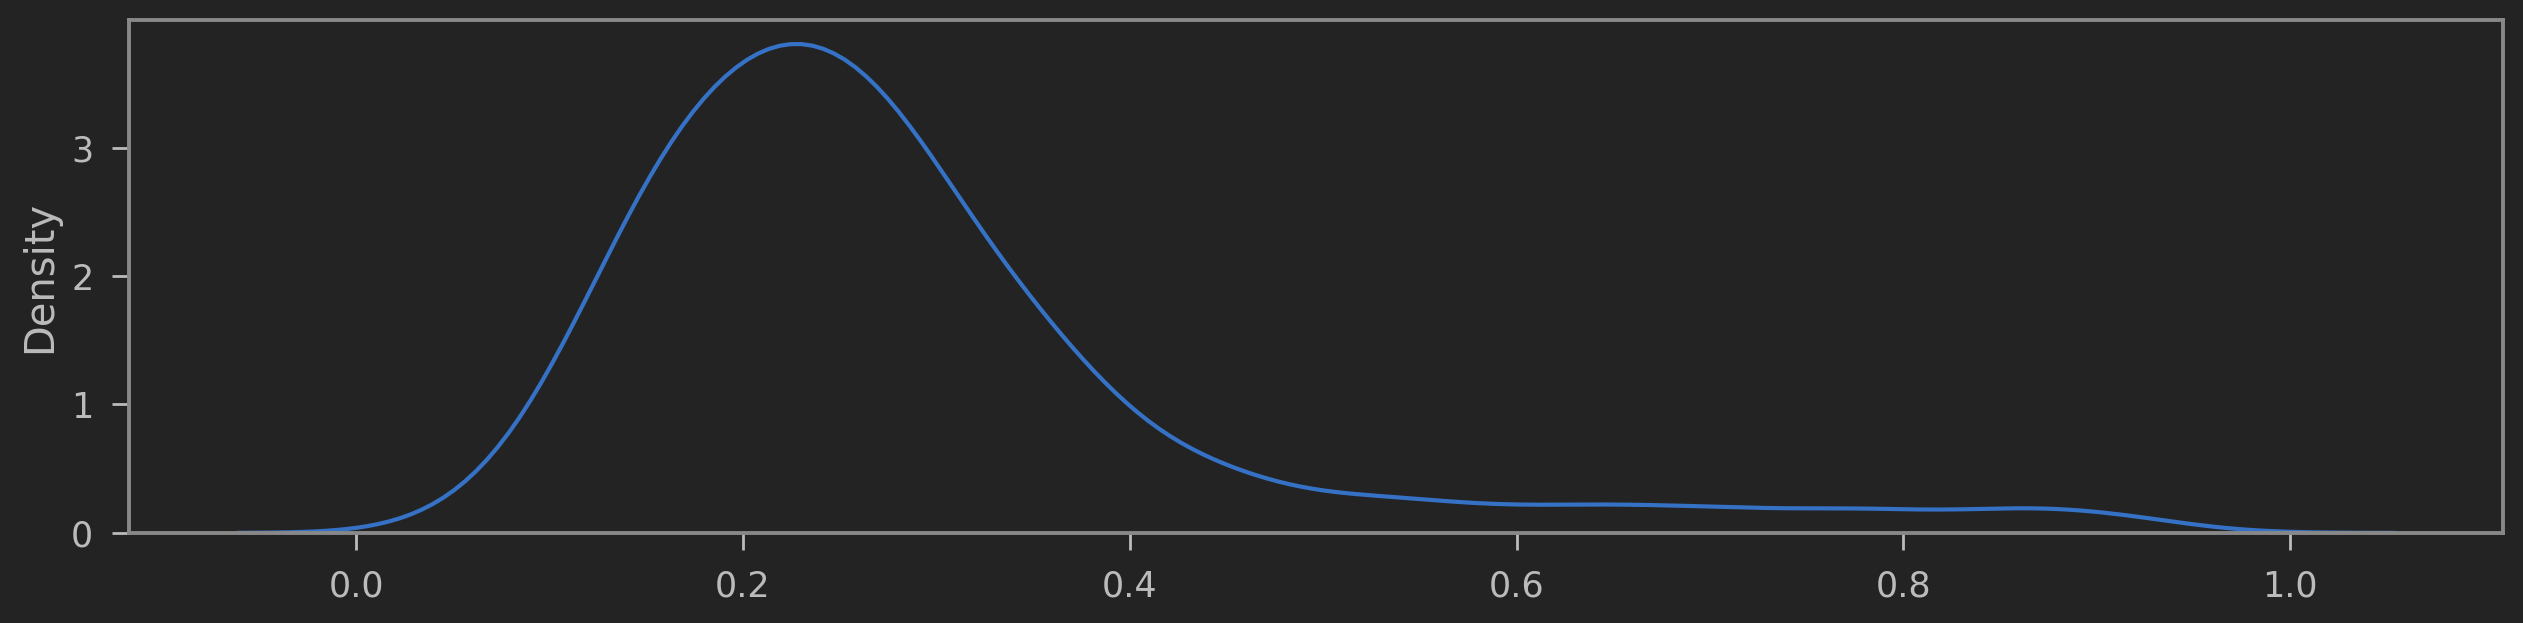

In [13]:
# az.plot_trace(svgd_approx.sample(2000)["freq_cheating"]);
figsize(12.5, 3)
sns.kdeplot(svgd_approx.sample(2000)["freq_cheating"], label="SVGD");

## Visualization With ArviZ
---

<img src="./Images/arvizLogo.png" alt="PyMC3 logo" style="height: 200px; width:600px;"/>

As we have already seen, there are a couple of different ways in which we can visualize our data. The most common way is to throw everything into a matplotlib histogram but that can get tedious and repetitive. Thankfully, PyMC3 now includes the ArviZ module which is awesome. ArviZ is a generalized package for Bayesian visualization so it has support for all of the major inferencing libraries including PySTAN, Pyro, TensorFlow Probability, NumPy, and of course PyMC3. Additionally, we have access to Seaborn which is a overarching statistics graphing module and not specifically for Bayesian Inference.

**A couple of notes:** Because ArviZ is an _'agnostic tools for diagnostics and visualizations of Bayesian inference in Python'_ it technically has its own way of dealing with things with the `InferenceData` and `xarray` data structures. With that said, PyMC3 has direct support for it as it's now the dedicated visualization library. When sampling, there is an option to `return_inferencedata` which will return the trace as an ArviZ InferenceData type. Check out the documentation to see all of the options: 


In [83]:
################### SAMPLE MODELS #############################
# viz_trace = np.random.standard_normal(800000)
with pm.Model() as viz_model:
    mu = pm.Normal('mu', 0, 1)
    sd = pm.HalfNormal('sd', 1)
    x = pm.Normal('x', mu=mu, sigma=sd, observed=[np.random.randn(10)])
    viz_trace = pm.sample(8000, return_inferencedata=True)
centered = az.load_arviz_data('non_centered_eight')
coords = {'school': ['Deerfield']}

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sd, mu]


Sampling 4 chains for 1_000 tune and 8_000 draw iterations (4_000 + 32_000 draws total) took 5 seconds.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.


,mean,sd,hdi_3%,hdi_97%
mu,0.012,0.268,-0.500,0.517
sd,0.855,0.211,0.526,1.253


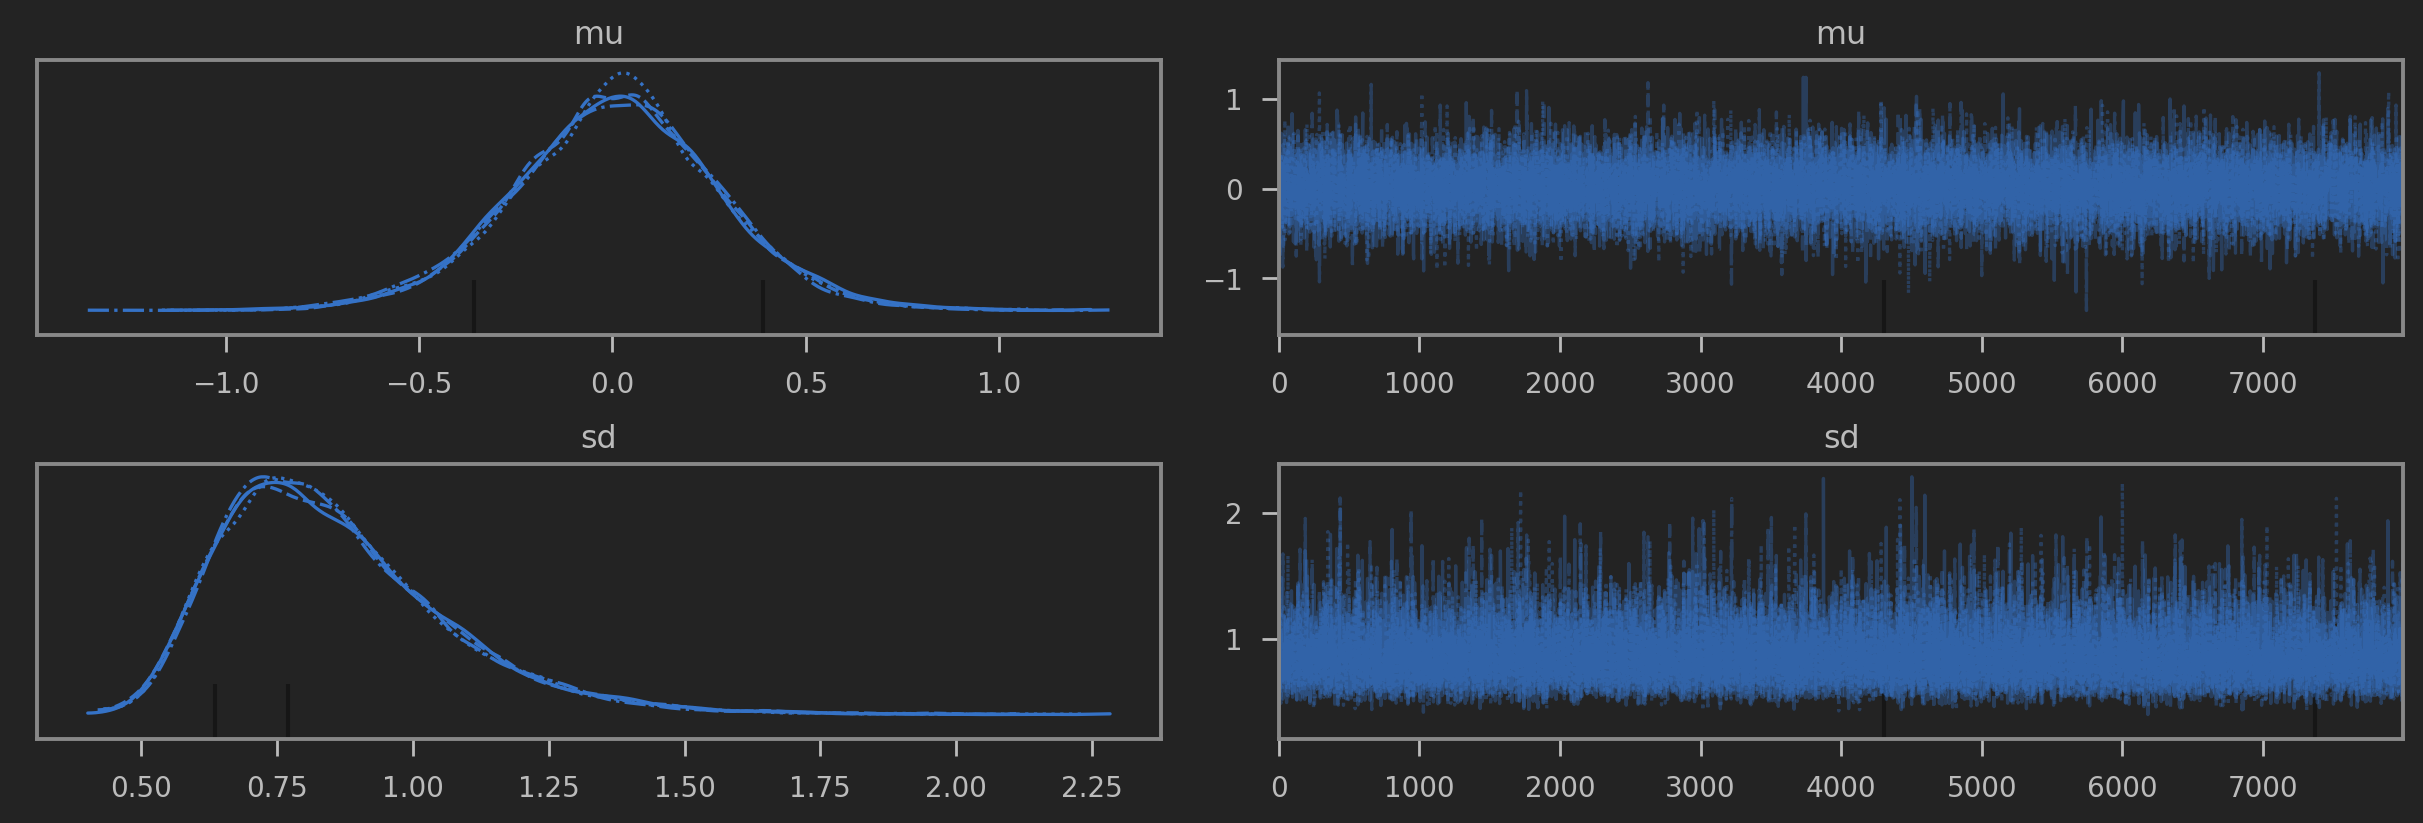

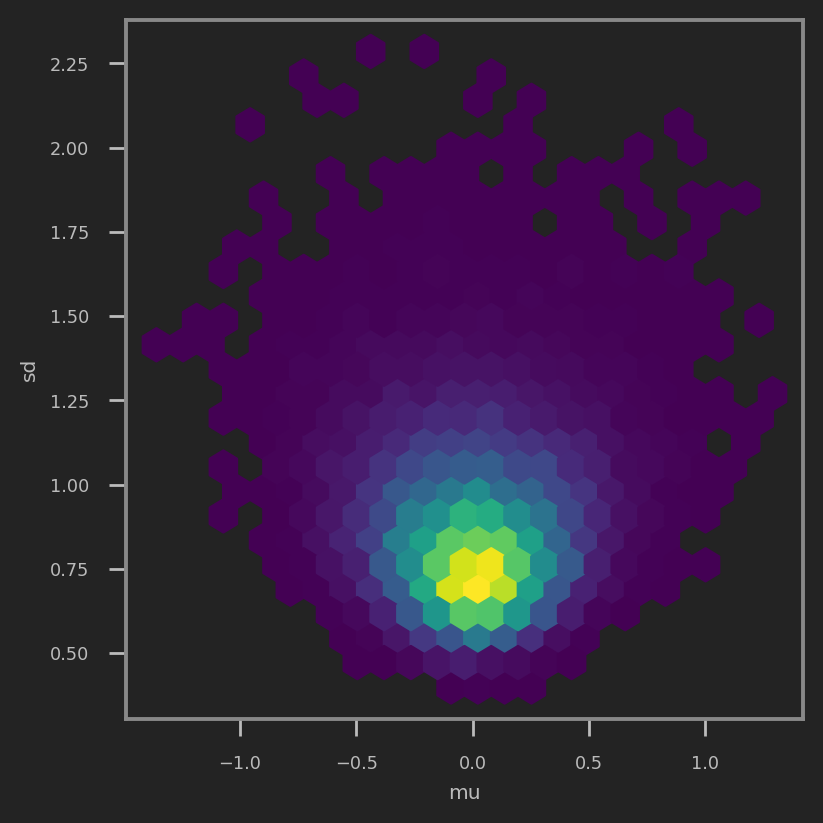

In [88]:
az.plot_trace(viz_trace)
az.plot_pair(
    viz_trace,
    var_names=['mu', 'sd'],
    kind='hexbin',
    figsize=(4,4)
)
az.summary(viz_trace, kind="stats")

## Under the Hood
---
### Theano/Aesara
<img src="./Images/1200px-Theano_logo.svg.png" alt="PyMC3 logo" style="height: 100px; width:450px;"/>
Theano is a tensor library developed by Montreal Institute for Learning Algorithms (MILA) that was discontinued in 2017 due to the rise in popularity with Google's TensorFlow and other projects. This left the devs at PyMC in a bit of a pickle since their back-end relied on Theano for quick computations. While an effort was made to switch over to TensorFlow under a new PyMC version (PyMC4), the attempt was scrapped. TensorFlow is a dynamic graph framework which is great for evolving neural nets, but adds too much overhead for PyMC's needs whereas Theano was a static graph library and thus much faster. The decision was made for the pymc community to fork Theano under the name Aesara and maintain it themselves. [The official announcement](https://pymc-devs.medium.com/the-future-of-pymc3-or-theano-is-dead-long-live-theano-d8005f8a0e9b) can be found here.

### Markov Chain Monte Carlo (NUTS/HMC)

_Features next-generation Markov chain Monte Carlo (MCMC) sampling algorithms such as the No-U-Turn Sampler (NUTS; Hoffman, 2014), a self-tuning variant of Hamiltonian Monte Carlo (HMC; Duane, 1987). This class of samplers works well on high dimensional and complex posterior distributions and allows many complex models to be fit without specialized knowledge about fitting algorithms. HMC and NUTS take advantage of gradient information from the likelihood to achieve much faster convergence than traditional sampling methods, especially for larger models. NUTS also has several self-tuning strategies for adaptively setting the tunable parameters of Hamiltonian Monte Carlo, which means you usually don’t need to have specialized knowledge about how the algorithms work. PyMC3, Stan (Stan Development Team, 2014), and the LaplacesDemon package for R are currently the only PP packages to offer HMC._

### JAX/AutoDiff/XLA

<img src="./Images/jaxLogo.png" alt="JAX logo" style="height: 125px; width:200px;"/>

JAX is Autograd and XLA, brought together for high-performance machine learning research.  

With its updated version of Autograd, JAX can automatically differentiate native Python and NumPy functions. It can differentiate through loops, branches, recursion, and closures, and it can take derivatives of derivatives of derivatives. It supports reverse-mode differentiation (a.k.a. backpropagation) via grad as well as forward-mode differentiation, and the two can be composed arbitrarily to any order.  

What’s new is that JAX uses XLA to compile and run your NumPy programs on GPUs and TPUs. Compilation happens under the hood by default, with library calls getting just-in-time compiled and executed. But JAX also lets you just-in-time compile your own Python functions into XLA-optimized kernels using a one-function API, jit. Compilation and automatic differentiation can be composed arbitrarily, so you can express sophisticated algorithms and get maximal performance without leaving Python. You can even program multiple GPUs or TPU cores at once using pmap, and differentiate through the whole thing.  

Dig a little deeper, and you'll see that JAX is really an extensible system for composable function transformations. Both grad and jit are instances of such transformations. Others are vmap for automatic vectorization and pmap for single-program multiple-data (SPMD) parallel programming of multiple accelerators, with more to come.

## Pros and Cons
---
**Pros:**
+ Good Community Support
+ Decent documentation
+ Mini batch inference
+ Easy to use
+ Theano/Aesara/JAX/XLA make for fast GPU computations
+ Offers Hamiltonian Monte Carlo/NUTS for self tuning, gradient based Markov Chain Monte Carlo

**Cons:**
+ Not as documented as STAN or BUGS
+ Newer in terms of probabilistic programing 
+ Not a universal PPL

## Other Python PPLs

---
### Pyro
<img src="./Images/pyroLogo.png" alt="Pyro logo" style="height: 200px; width:200px;"/>
Pyro is a universal probabilistic programming language (PPL) written in Python and supported by PyTorch on the backend. Pyro enables flexible and expressive deep probabilistic modeling, unifying the best of modern deep learning and Bayesian modeling. It was designed with these key principles:

+ **Universal:** Pyro can represent any computable probability distribution.
+ **Scalable:** Pyro scales to large data sets with little overhead.
+ **Minimal:** Pyro is implemented with a small core of powerful, composable abstractions.
+ **Flexible:** Pyro aims for automation when you want it, control when you need it. 

Now includes **NumPyro** in the back-end which used JAX and JIT for HMC and NUTS implementations

### Edward
<img src="./Images/edwardLogo.png" alt="Edward logo" style="height: 200px; width:200px;"/>

Edward is a Python library for probabilistic modeling, inference, and criticism. It is a testbed for fast experimentation and research with probabilistic models, ranging from classical hierarchical models on small data sets to complex deep probabilistic models on large data sets. Edward fuses three fields: Bayesian statistics and machine learning, deep learning, and probabilistic programming.

+ It supports modeling with
    + Directed graphical models
    + Neural networks (via libraries such as tf.layers and Keras)
    + Implicit generative models
    + Bayesian nonparametrics and probabilistic programs
+ It supports inference with
    + Variational inference
        + Black box variational inference
        + Stochastic variational inference
        + Generative adversarial networks
        + Maximum a posteriori estimation
    + Monte Carlo
        + Gibbs sampling
        + Hamiltonian Monte Carlo
        + Stochastic gradient Langevin dynamics
    + Compositions of inference
        + Expectation-Maximization
        + Pseudo-marginal and ABC methods
        + Message passing algorithms
+ It supports criticism of the model and inference with
    + Point-based evaluations
    + Posterior predictive checks

Edward is built on TensorFlow. It enables features such as computational graphs, distributed training, CPU/GPU integration, automatic differentiation, and visualization with TensorBoard.

# Resources
---

+ PyMC3 Stuff
    + [PyMC3 github](https://github.com/pymc-devs/pymc3)
    + [Probabilistic Programming and Bayesian Methods for Hackers](https://github.com/CamDavidsonPilon/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers)
    + [Getting Started](https://docs.pymc.io/notebooks/getting_started.html)
    + [Thomas Wiecki's Blog](https://twiecki.io/)
    + [JAX github](https://github.com/google/jax)
    + [The No-U-Turn Sampler (NUTS)](http://www.stat.columbia.edu/~gelman/research/published/nuts.pdf)
    + [Prior and Posterior Checks](https://colcarroll.github.io/pymc3/notebooks/posterior_predictive.html)

+ Visualization Libraries
    + [ArviZ: A Bayesian Visualization Library](https://arviz-devs.github.io/arviz/)
    + [Seaborn](https://seaborn.pydata.org/)
    + [MatPlotLib](https://matplotlib.org/stable/index.html)

+ Other Python PPLs
    + [Pyro](http://pyro.ai/)
    + [PySTAN](https://pystan.readthedocs.io/en/latest/)
    + [Edward](http://edwardlib.org/)

+ Articles on Bayesian/Variational Inference
    + [Hands on Bayesian Inference](https://towardsdatascience.com/hands-on-bayesian-statistics-with-python-pymc3-arviz-499db9a59501)
    + [Bayesian Inference with MCMC and VI](https://towardsdatascience.com/bayesian-inference-problem-mcmc-and-variational-inference-25a8aa9bce29)
    + [PyMC3 vs PySTAN vs Edward](https://towardsdatascience.com/stan-vs-pymc3-vs-edward-1d45c5d6da77)
    
+ Random Stuff
    + [The Future of PyMC3, or: Theano is Dead, Long Live Theano](https://pymc-devs.medium.com/the-future-of-pymc3-or-theano-is-dead-long-live-theano-d8005f8a0e9b)
    + [Probability Theory: The Logic of Science](http://www.med.mcgill.ca/epidemiology/hanley/bios601/GaussianModel/JaynesProbabilityTheory.pdf)
    + [Planning Algorithms](http://planning.cs.uiuc.edu/booka4.pdf)
    + [Understanding Robotics](http://underactuated.mit.edu/index.html)
    + [Pyro vs PyMC3 vs Edward](https://tomasfiers.net/posts/probabilistic-python/)
    + [Stien Variation Gradient Decent](http://www.depthfirstlearning.com/2020/SVGD)

# IGNORE: notes on what to present

1. Summary of what PyMC3 is
    + History
    + Underlying technologies
    + Features
    
2. Some basic examples
    + Generate fake data and do some neat inference on it
    + Demonstrate niffty syntax
    
3. Visualization
    + MatPlotLib/MPL_toolkit_3D
    + Seaborn
    + ArviZ

3. Under the hood stuff
    + MCMC
    + VI/ADVI
    + JAX
    + Aesara/Theano
    
5. Pros and Cons

6. A review on other python PPL's
    + Pyro
        - Variational Inference based
        - Based on PyTorch
    + Edward
        - TensorFlow rather than Theano
    + PySTAN
        - Well.... STAN based
        
7. Reasources

# Machine Learning Applications

In [14]:
import pandas as pd
import theano.tensor as tt
import theano

from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split

X, y = load_iris(True)
X_train, X_test, y_train, y_test = train_test_split(X, y)

Xt = theano.shared(X_train)
yt = theano.shared(y_train)

with pm.Model() as iris_model:

    # Coefficients for features
    β = pm.Normal("β", 0, sigma=1e2, shape=(4, 3))
    # Transoform to unit interval
    a = pm.Flat("a", shape=(3,))
    p = tt.nnet.softmax(Xt.dot(β) + a)

    observed = pm.Categorical("obs", p=p, observed=yt)
    
with iris_model:

    # We'll use SVGD
    inference = pm.SVGD(n_particles=500, jitter=1)

    # Local reference to approximation
    approx = inference.approx

    # Here we need `more_replacements` to change train_set to test_set
    test_probs = approx.sample_node(p, more_replacements={Xt: X_test}, size=100)

    # For train set no more replacements needed
    train_probs = approx.sample_node(p)

test_ok = tt.eq(test_probs.argmax(-1), y_test)
train_ok = tt.eq(train_probs.argmax(-1), y_train)
test_accuracy = test_ok.mean(-1)
train_accuracy = train_ok.mean(-1)

eval_tracker = pm.callbacks.Tracker(
    test_accuracy=test_accuracy.eval, train_accuracy=train_accuracy.eval
)

inference.fit(100, callbacks=[eval_tracker]);

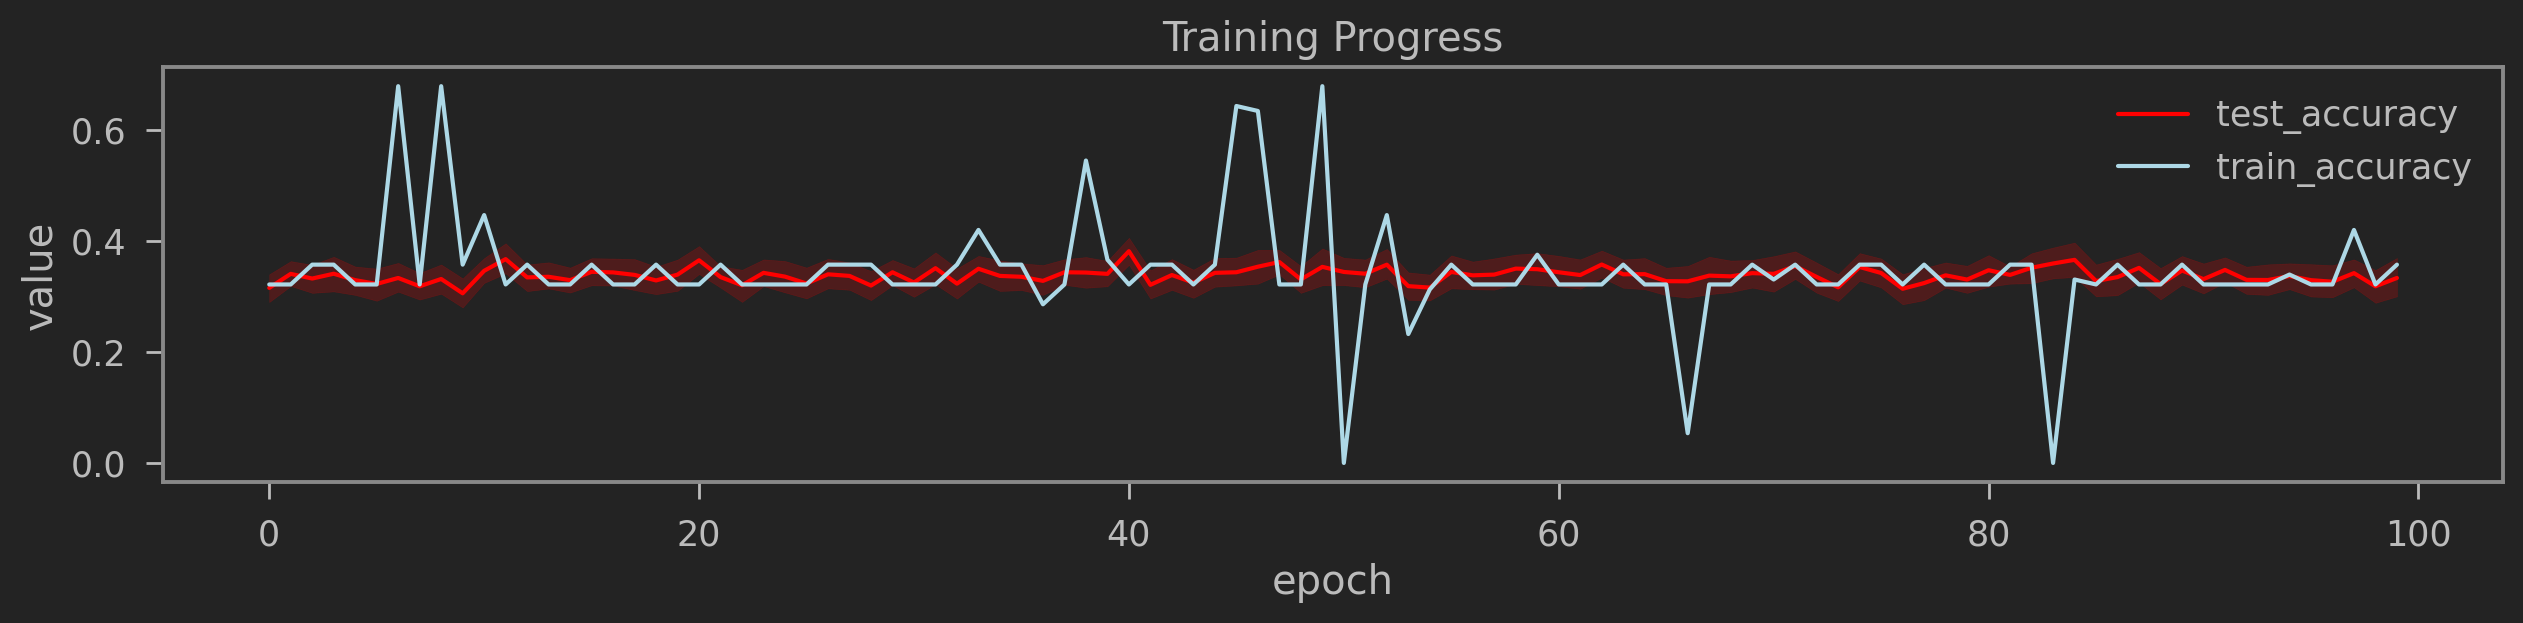

In [15]:
_, ax = plt.subplots(1, 1)
df = pd.DataFrame(eval_tracker["test_accuracy"]).T.melt()
sns.lineplot(x="variable", y="value", data=df, color="red", ax=ax)
ax.plot(eval_tracker["train_accuracy"], color="lightblue")
ax.set_xlabel("epoch")
plt.legend(["test_accuracy", "train_accuracy"])
plt.title("Training Progress");



In [16]:
inference.fit(400, obj_optimizer=pm.adamax(learning_rate=0.1), callbacks=[eval_tracker]);

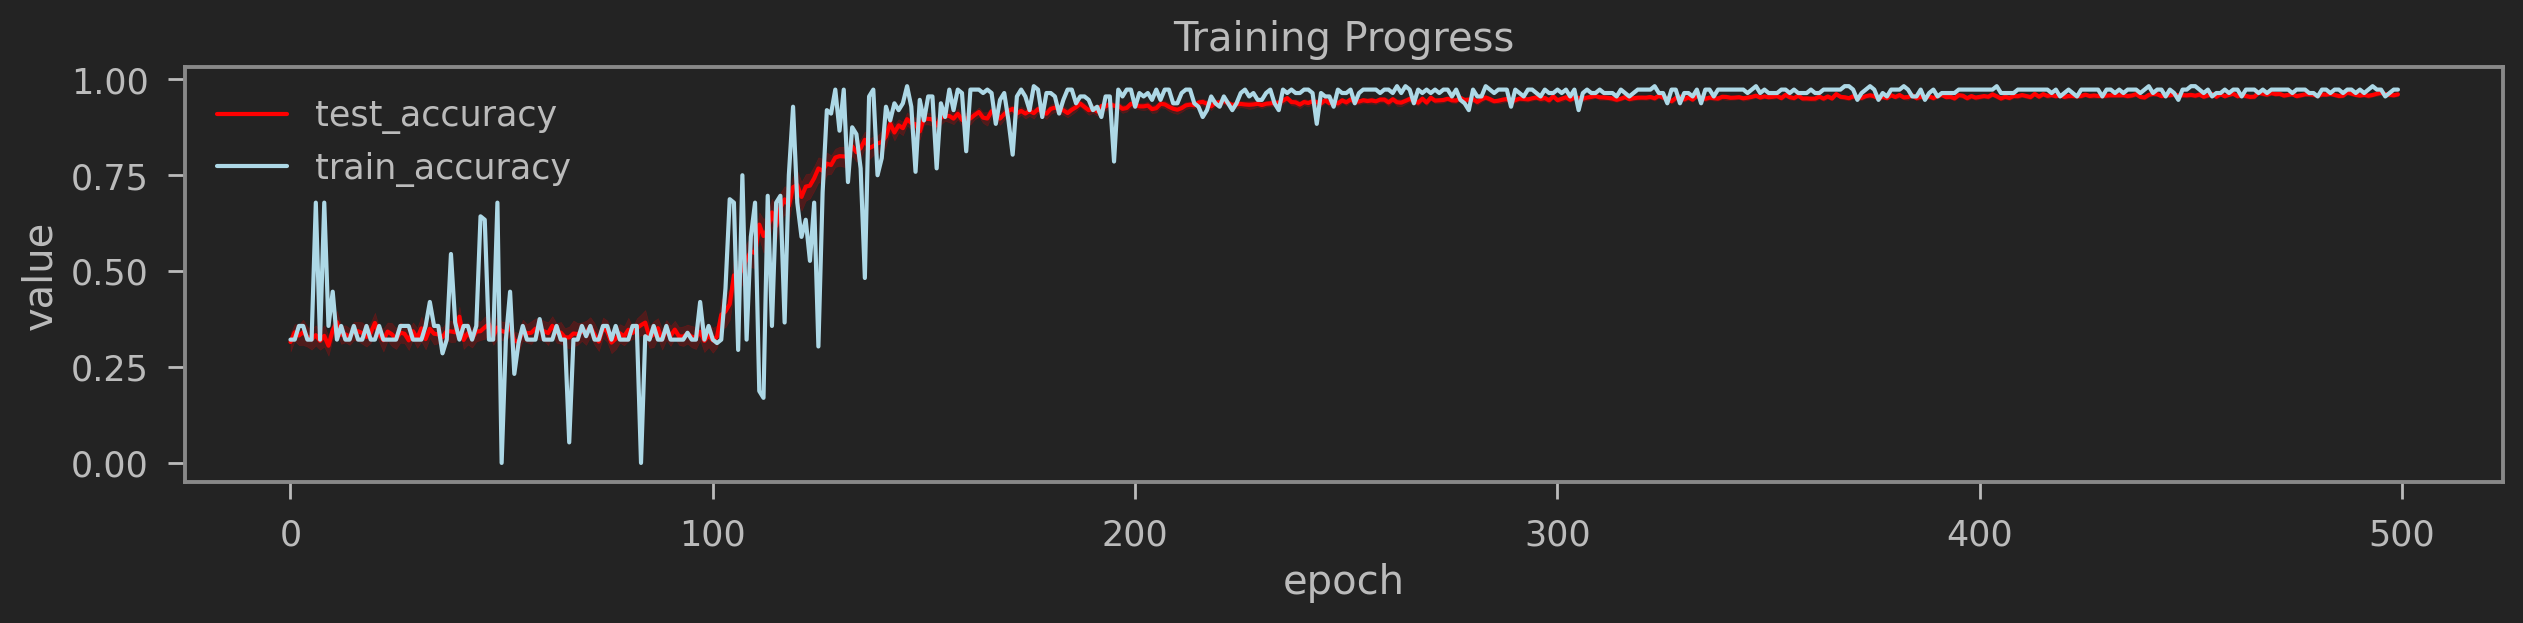

In [17]:
_, ax = plt.subplots(1, 1)
df = pd.DataFrame(np.asarray(eval_tracker["test_accuracy"])).T.melt()
sns.lineplot(x="variable", y="value", data=df, color="red", ax=ax)
ax.plot(eval_tracker["train_accuracy"], color="lightblue")
ax.set_xlabel("epoch")
plt.legend(["test_accuracy", "train_accuracy"])
plt.title("Training Progress");

